<a href="https://colab.research.google.com/github/lizzij/GFlowNets-DNA-Motif/blob/main/Gibbs_Sampling_vs_GFlowNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
"Motif finding" in yeast, bacteria can be reduced to the problem of finding a set of common substrings within a set of strings. It is useful for finding transcription factor binding sites.

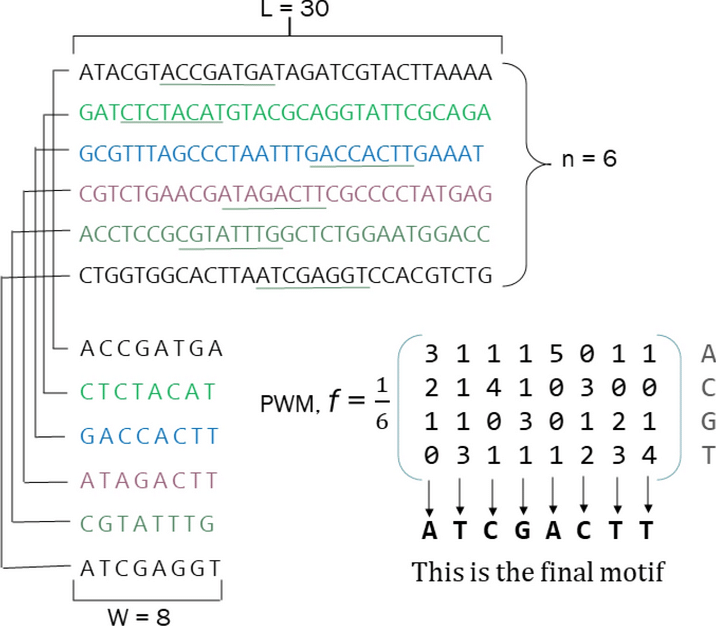

A Given $p$ sequences, find the most mutually similar length-$k$ subsequences, one from each sequence:

<center>$\underset{s_1, ..., s_p}{\operatorname{argmax}}  \sum_{i<j} \text{dist}(s_i, s_j)$</center>

$\text{dist}(s_i, s_j)$ is the Hamming distance between $s_i$ and $s_j$.

# Dataset
Yeast Saccharomyces cerevisiae chromosome X [dataset](https://www.yeastgenome.org/contig/Chromosome_X), strain S288C, length 745751 bases.

[YeTFaSCo](http://yetfasco.ccbr.utoronto.ca/) is a collection of all available TF specificities for the yeast Saccharomyces cerevisiae in Position Frequency Matrix (PFM) or Position Weight Matrix (PWM) formats. 

In [ ]:
!pip install -q modisco

In [ ]:
import numpy as np
import modisco
import sys
import os

In [ ]:
# grab TAL GATA data
![[ -f sequences.simdata.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
![[ -f test.txt.gz ]] || wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

In [ ]:
# read in the data in the testing set
import gzip

test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

print(f'Number of DNA sequences: {len(fasta_sequences)}')
print(f'Each DNA sequence length: {len(fasta_sequences[0])}')
print(f'Example DNA sequence: {fasta_sequences[100]}')

Number of DNA sequences: 800
Each DNA sequence length: 200
Example DNA sequence: GGGAATATAAGTACTCGATGGACGGACACACTAGCTATTTTCCGGTTCGAGAGCTGATAAGGACTAGGTTTGGACATATTAAAACCAAAGAAAACTTGTTTTGCTATAAAGTATTGAGATCCGTACGACGTACAGATGTCCCGAGCGTGATGTAAGGCTTTGAGGGAGCCAAAGGCCTTCCTCCAGATGGTGGTGGGTGA


In [ ]:
# one hot encoding for ATGC
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

n = 100 # limit to 100 sequences
take_ratio = n / len(fasta_sequences)
take_rc = (np.random.RandomState(1234).uniform(size=n) > take_ratio)
onehot_data = [one_hot_encode_along_channel_axis(seq) if not rc else
               one_hot_encode_along_channel_axis(seq)[::-1,::-1]
               for seq,rc in zip(fasta_sequences[:n], take_rc)]

print(f'Number of one hot sequences: {len(onehot_data)}')
print(f'Each one hot sequence length: {len(onehot_data[0])}')

Number of one hot sequences: 100
Each one hot sequence length: 200


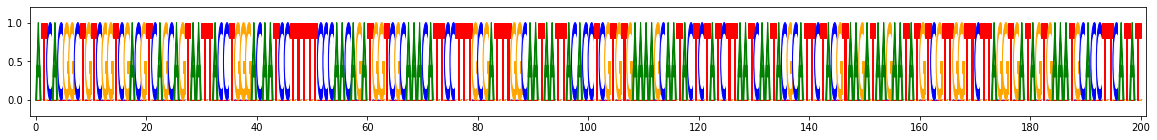

In [ ]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(onehot_data[50], subticks_frequency=20)

# Gibbs Sampling

Repeatedly leave one sequence out and optimize the motif location in the left-out sequence. 

Gibbs sampling and Expectation Maximization works well on simpler sequences, like yeast and bacteria DNA.
   - CONSENSUS (Hertz and Stormo, 1999)
   - MEME (Bailey and Elkan, 1994), and 
   - AlignACE (Roth et al., 1998)

In [ ]:
import gibbs_sampling

def get_sampled_subsequences(example_sequences, motif_length):
  starting_positions = gibbs_sampling.generate_motif(example_sequences, motif_length)
  subsequences = [sequence[start_index: start_index + motif_length] 
                  for sequence, start_index 
                  in zip(example_sequences, starting_positions)]
  return subsequences

In [ ]:
word_sequences = ['dog', 'doggo', 'godot']
motif_length = 2

for i in range(10):
  subsequences = get_sampled_subsequences(word_sequences, motif_length)
  print(subsequences)

['do', 'do', 'do']
['og', 'og', 'ot']
['do', 'do', 'do']
['og', 'og', 'go']
['og', 'og', 'ot']
['og', 'go', 'ot']
['do', 'do', 'do']
['do', 'do', 'do']
['og', 'gg', 'od']
['do', 'gg', 'ot']


In [ ]:
small_dna_sequences = [seq[:20] for seq in fasta_sequences[:10]]
motif_length = 8
print(small_dna_sequences)

# limiting to 5 training iterations for now
for i in range(10):
  subsequences = get_sampled_subsequences(small_dna_sequences, motif_length)
  print(subsequences)

['CTTGTATTGAGTTAGAAACC', 'TGACAATGGACCCGGTCCGG', 'CGTTTGAAAGGAGACCAGGT', 'TATGACGACTGCGTATAGTA', 'CAGTATCTACTGAAAGGAGA', 'TCAAAGCATCCTGGCTGCAG', 'GCACTAACCCACCTGGCTAT', 'TCACCAATTGGCGGTGCCCG', 'ATCGAAGTTATTACACAGGT', 'AAATTGAGCACTTTGATGTA']
['TTGTATTG', 'GGACCCGG', 'AGACCAGG', 'GCGTATAG', 'ATCTACTG', 'CATCCTGG', 'CCACCTGG', 'CCAATTGG', 'TTACACAG', 'GCACTTTG']
['TGAGTTAG', 'GGACCCGG', 'GACCAGGT', 'CGACTGCG', 'CTACTGAA', 'AAGCATCC', 'CCACCTGG', 'TGGCGGTG', 'ACACAGGT', 'GCACTTTG']
['TTAGAAAC', 'ATGGACCC', 'TTTGAAAG', 'ATGACGAC', 'ACTGAAAG', 'TCAAAGCA', 'ACTAACCC', 'GCGGTGCC', 'ATTACACA', 'ATTGAGCA']
['TAGAAACC', 'TGACAATG', 'TTGAAAGG', 'TGCGTATA', 'CTGAAAGG', 'CCTGGCTG', 'CACCTGGC', 'TGGCGGTG', 'TCGAAGTT', 'ATTGAGCA']
['TAGAAACC', 'GACCCGGT', 'AGGAGACC', 'CGACTGCG', 'TATCTACT', 'ATCCTGGC', 'CACCTGGC', 'CAATTGGC', 'TACACAGG', 'CACTTTGA']
['TGAGTTAG', 'GGACCCGG', 'AGACCAGG', 'ACGACTGC', 'CTGAAAGG', 'CTGGCTGC', 'CCACCTGG', 'TTGGCGGT', 'TCGAAGTT', 'TTTGATGT']
['GTATTGAG', 'ATGGACCC', 'CGTTTGA

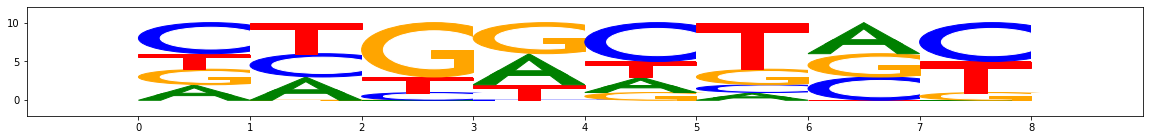

In [ ]:
onehot_motif = sum([one_hot_encode_along_channel_axis(subsequence) for subsequence in subsequences])
viz_sequence.plot_weights(onehot_motif, subticks_frequency=1)

# GFlowNets
Sample proportional to final reward.

In [ ]:
import torch
import itertools

In [ ]:
def hemming_distance(x: str, y: str) -> int:
  len_filled = max(len(x),len(y)) # ensure both binary strings are of same length
  x_filled = x.zfill(len_filled)
  y_filled = y.zfill(len_filled)

  count = 0
  for i in range(len_filled):
      if x_filled[i] != y_filled[i]: #count every instance where bits are different
          count +=1
  return count

hemming_distance('AAATTT', 'GGGTT')

4

In [ ]:
def reward_function(subsequences):
  combos = itertools.combinations(subsequences, 2)
  total_hemming_distances = sum([hemming_distance(x, y) for x, y in combos])
  return 1 / total_hemming_distances

subsequences = ['ACTG', 'ACTG', 'ACTG', 'ACCG']
reward_function(subsequences)

3

In [ ]:
reward_coef = 11

vocab = ['A', 'C', 'G', 'T', ',', '.'] 
pad_index = 4  # pad token is ,
eos_index = 5  # EOS token is .

vocab_size = len(vocab)
max_length = 8 + 1  # motif length of 8, 1 BOS

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
import itertools
import numpy as np

def Embedding(num_embeddings, embedding_dim, padding_idx=None):
    m = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)
    return m

def get_padding_masks(slen, lengths):
    """
    Generate hidden states mask
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]
    # sanity check
    assert mask.size() == (bs, slen)
    return mask

class TransformerModel(nn.Module):

    # params : n_words, eos_index, pad_index, emb_dim

    def __init__(self, params, transformer_layers):
        """
        Transformer model 
        """
        super().__init__()
        # embeddings : one hot is better in this case
        self.embeddings = Embedding(params.n_words, params.emb_dim, padding_idx=params.pad_index)
        # This can be replace by transformer model from torch.nn, huggingface transoformer ...
        self.transformer = transformer_layers

    def forward(self, x, lengths):
        """
        Inputs:
            `x` LongTensor(bs, slen), containing word indices
            `lengths` LongTensor(bs), containing the length of each sentence
        """
        #padding_mask = x != self.pad_index
        #lengths = padding_mask.long().sum(dim=1).to(x.device)
        
        # check inputs
        bs, slen = x.size()
        assert lengths.size(0) == bs
        assert lengths.max().item() <= slen

        # generate masks
        mask = get_padding_masks(slen, lengths)

        # embeddings
        tensor = self.embeddings(x)
        tensor *= mask.unsqueeze(-1).to(tensor.dtype)
        
        # transformer layers
        tensor = self.transformer(tensor)
        
        return tensor

In [ ]:
def make_mlp(l, act=nn.LeakyReLU(), tail=[]):
    """makes an MLP with no top layer activation"""
    return nn.Sequential(*(sum(
        [[nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))

## Train GFlowNets

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
params = AttrDict({
    "n_words": vocab_size, 
    "pad_index": pad_index, 
    "eos_index": eos_index, 
    "emb_dim": 100, 
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
xs = torch.arange(0, int("".join(["A"]*max_length)))
all_rewards = reward_function(xs, reward_coef)
print('total reward', xs, all_rewards.view(-1).logsumexp(0))
true_dist = all_rewards.softmax(0).cpu().numpy()
print('true dist', true_dist)

In [ ]:
Z = torch.ones((1,)).to(device)

n_hid = 256
n_layers = 2

mlp = make_mlp([params.emb_dim] + [n_hid] * n_layers + [params.n_words]).to(device)  # [100, 256, 256, 12]
model = TransformerModel(params, mlp).to(device)
P_B = 1 # DAG & sequence generation => tree 


optim = torch.optim.Adam([ {'params':model .parameters(), 'lr':0.001}, {'params':[Z], 'lr':0.01} ])
Z.requires_grad_()

In [ ]:
import tqdm

losses_TB = []
zs_TB = []
rewards_TB = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

In [ ]:
batch_size = 128
max_len = max_length

n_train_steps = 5000

for it in tqdm.trange(n_train_steps):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    # Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    flag = True
    if flag :
        # detached form  of TB
        ll_diff = torch.zeros((batch_size,)).to(device)
        ll_diff += Z
    else :
        # non-detached form of TB ojective, where we multiply everything before doing the logarithm
        in_probs = torch.ones(batch_size, dtype=torch.float, requires_grad=True).to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        #scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores = tensor.sum(dim=1) # (bs, vocab_size) 
        scores[:,pad_index] = -1e8 # we don't want to generate pad_token
        scores[:,eos_index] = -1e8 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        scores = scores.log_softmax(1)
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1

        # loss
        if flag :
            #sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            #sample_in_probs[unfinished_sents == 0] = 1.
            #ll_diff += sample_in_probs.log()
            
            ll_diff += scores.gather(1, next_words.unsqueeze(-1)).squeeze(1)
        else :
            sample_in_probs = probs.gather(1, next_words.unsqueeze(-1)).squeeze(1)
            sample_in_probs[unfinished_sents == 0] = 1.
            in_probs = in_probs * sample_in_probs
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function(generated, reward_coef).to(device) 
    
    optim.zero_grad()
    if flag :
        ll_diff -= R.log()
        loss = (ll_diff**2).sum()/batch_size
    else :
        loss = ((Z*in_probs / R).log()**2).sum()/batch_size

    loss.backward()
    optim.step()

    losses_TB.append(loss.item())
    zs_TB.append(Z.item())
    rewards_TB.append(R.mean().cpu())
    all_visited_TB.extend(generated)
    for state in all_visited_TB :
        if first_visit_TB[int(state)]<0: first_visit_TB[int(state)] = it

    if it%1000==0: 
        print('loss =', np.array(losses_TB[-100:]).mean(), 'Z =', Z.item(), "R =", np.array(rewards_TB[-100:]).mean() )
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))
        print("gen")
        print(generated[-100:])

In [ ]:
samples = []
samples_R = []

for it in tqdm.trange(10):
    generated = torch.LongTensor(batch_size, max_len)  # upcoming output
    generated.fill_(params.pad_index)       # fill upcoming ouput with <PAD>
    generated[:,0].fill_(params.eos_index)    # we use <EOS> for <BOS> everywhere as start token
    #gen_len = (state != params.pad_index).long().sum(dim=1).to(state.device)
    gen_len = torch.LongTensor(batch_size,).fill_(1)
    unfinished_sents = gen_len.clone().fill_(1)
    cur_len = 1
    #Z = Z(agent.model(generated[:,:cur_len], lengths=gen_len, causal=True)[:,0]).squeeze(1).exp().to(device)

    while cur_len < max_len:
        state = generated[:,:cur_len] + 0 # (bs, cur_len)
        tensor = model(state.to(device), lengths=gen_len.to(device)) # (bs, cur_len, vocab_size)
        scores = tensor[:,0] # (bs, vocab_size) : use last word for prediction
        scores[:,pad_index] = -1e2 # we don't want to generate pad_token
        scores[:,eos_index] = -1e2 # if we don't want to generate eos_token : don't allow generation of sentences with differents lengths
        sample_temperature = 1
        probs = F.softmax(scores / sample_temperature, dim=1)
        #next_words = torch.distributions.categorical.Categorical(probs=probs).sample()
        next_words = torch.multinomial(probs, 1).squeeze(1)

        # update generations / lengths / finished sentences / current length
        generated[:,cur_len] = next_words.cpu() * unfinished_sents + params.pad_index * (1 - unfinished_sents)
        gen_len.add_(unfinished_sents)
        unfinished_sents.mul_(next_words.cpu().ne(params.eos_index).long())
        cur_len = cur_len + 1
      
        # stop when there is a </s> in each sentence, or if we exceed the maximul length
        if unfinished_sents.max() == 0:
            break

    generated = generated.apply_(lambda index : 0 if index == pad_index or index == eos_index else index)
    #R = reward_function(generated, reward_coef).to(device)
    generated =  [float("".join([str(s_i) for s_i in s])) for s in generated.tolist()]
    R = reward_function(generated, reward_coef).to(device) 


    samples.extend(generated)  
    samples_R.extend([r.item() for r in R.cpu()]) 

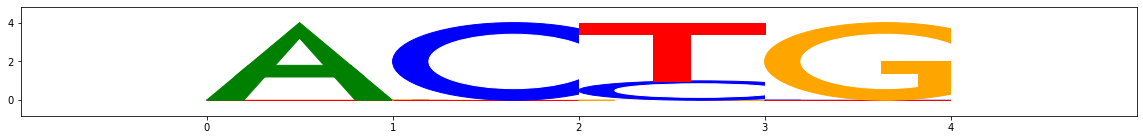

In [ ]:
onehot_motif = sum([one_hot_encode_along_channel_axis(subsequence) for subsequence in subsequences])
viz_sequence.plot_weights(onehot_motif, subticks_frequency=1)

# References

Lawrence CE, Altschul SF, Boguski MS, Liu JS, Neuwald AF, Wootton JC. Detecting subtle sequence signals: a Gibbs sampling strategy for multiple alignment. Science. 1993 Oct 8;262(5131):208-14. doi: 10.1126/science.8211139. PMID: 8211139.

Jain, Moksh, Emmanuel Bengio, Alex-Hernandez Garcia, Jarrid Rector-Brooks, Bonaventure F. P. Dossou, Chanakya Ekbote, Jie Fu, et al. “Biological Sequence Design with GFlowNets.” ArXiv:2203.04115 [Cs, q-Bio], March 2, 2022. http://arxiv.org/abs/2203.04115.

Pascal.Jr.Tikeng.Notsawo. References. Jupyter Notebook, 2022. https://github.com/Tikquuss/GflowNets_Tutorial.

